In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from tqdm import tqdm
import time
from torchvision import models

In [2]:
data_dir = "../input/plantdoc6721"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [3]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Corn leaf blight', 'Tomato leaf', 'Tomato leaf mosaic virus', 'Squash Powdery mildew leaf', 'Potato leaf late blight', 'Soyabean leaf', 'Peach leaf', 'Tomato leaf late blight', 'Apple leaf', 'Tomato mold leaf', 'Corn Gray leaf spot', 'Tomato leaf yellow virus', 'Strawberry leaf', 'Cherry leaf', 'Apple rust leaf', 'Potato leaf early blight', 'grape leaf black rot', 'Apple Scab Leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Blueberry leaf', 'Bell_pepper leaf spot', 'Corn rust leaf', 'Bell_pepper leaf', 'grape leaf', 'Tomato Early blight leaf', 'Raspberry leaf']
Total disease classes are: 27


In [4]:
plants = []
for plant in diseases:
    if plant.split(' ')[0] not in plants:
        plants.append(plant.split(' ')[0])

In [5]:
# Unique plants in the dataset
print("Number of Classes: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of Classes: 13
Unique Plants are: 
1. Corn
2. Tomato
3. Squash
4. Potato
5. Soyabean
6. Peach
7. Apple
8. Strawberry
9. Cherry
10. grape
11. Blueberry
12. Bell_pepper
13. Raspberry


In [6]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Corn leaf blight,192
Tomato leaf,63
Tomato leaf mosaic virus,53
Squash Powdery mildew leaf,128
Potato leaf late blight,105
Soyabean leaf,65
Peach leaf,112
Tomato leaf late blight,111
Apple leaf,90
Tomato mold leaf,91


Text(0.5, 1.0, 'Images per each class of plant disease')

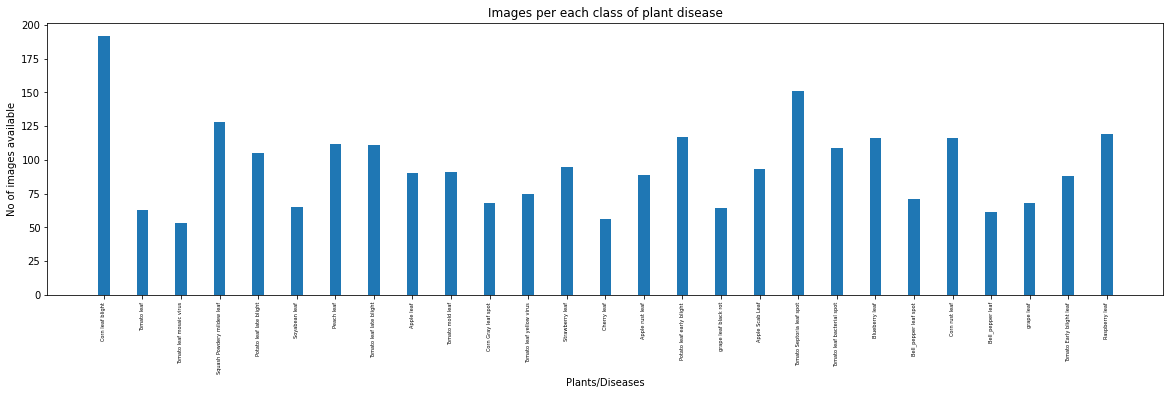

In [8]:
# plotting number of images available for each disease
index = [n for n in range(len(disease_class_size.values()))]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [10]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225]),
            transforms.Resize((224, 224))
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [11]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [12]:
len(train_dataset.dataset.imgs)

2566

In [13]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 17


In [14]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

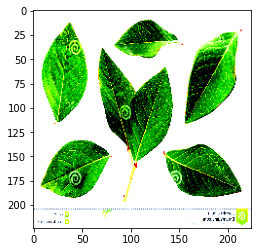

In [15]:
show_image(*train_dataset[21])

In [16]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [111]:
#len(train_dataset)

1797

In [17]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

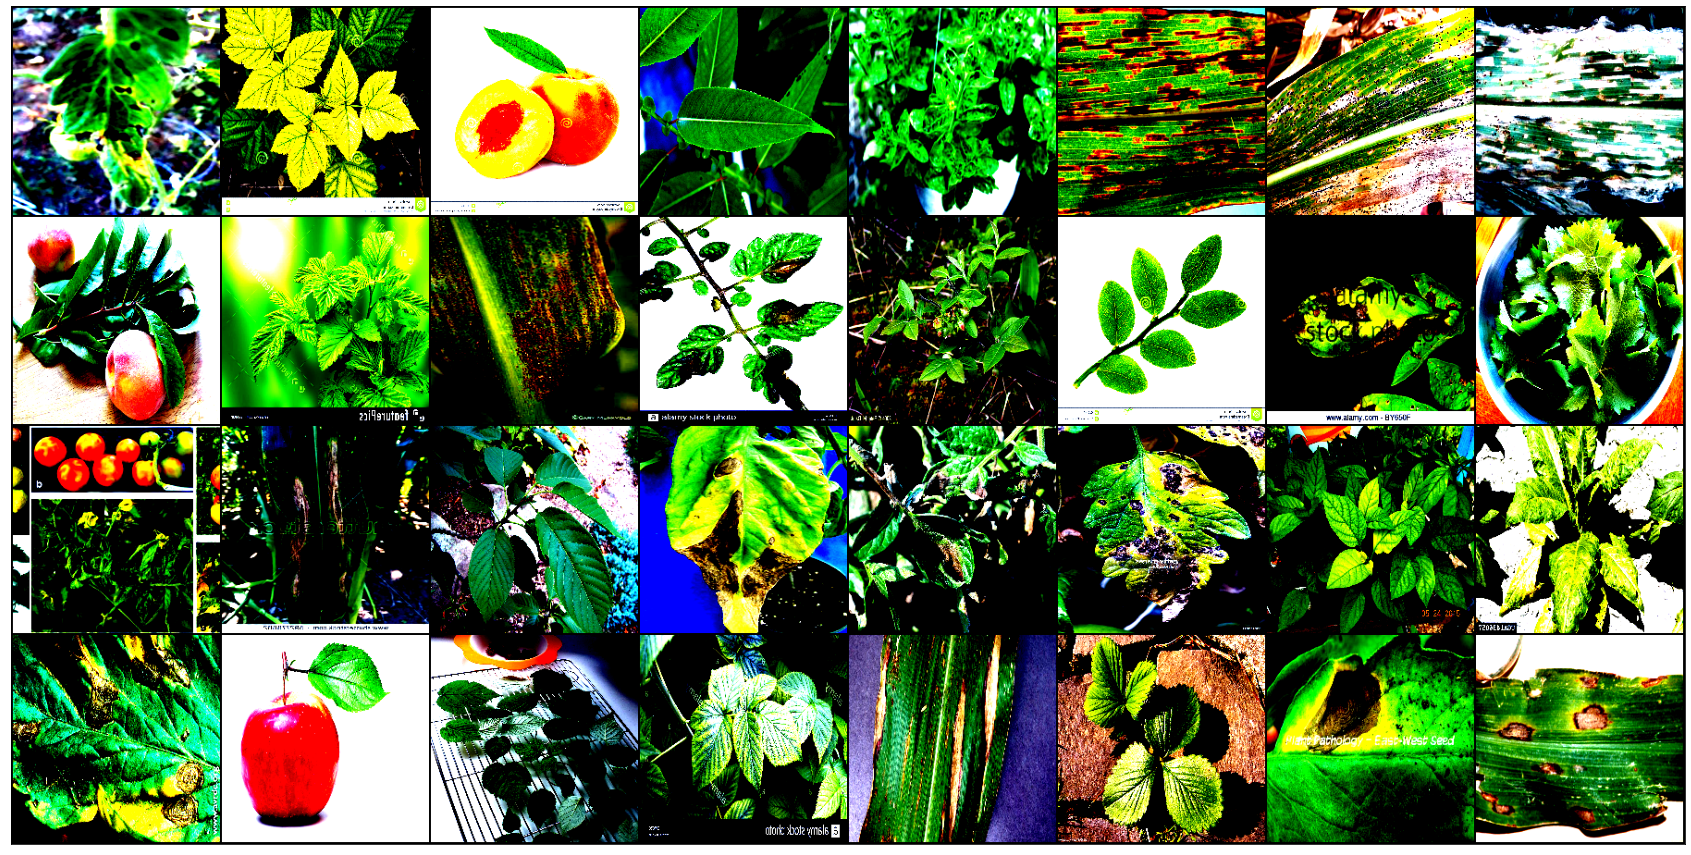

In [18]:
show_batch(train_dataloader)

In [19]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [20]:
# defining the model

model_vgg16 = models.vgg16(pretrained=True)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [21]:
for param in model_vgg16.parameters():
    param.requires_grad = False

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, out_features=len(train_dataset.dataset.classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg16.classifier[6].parameters(), lr=0.001)

Device: cuda:0


In [22]:
accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []

num_epochs = 20
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 10 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_vgg16.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_vgg16(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                # print("Correct-> ", correct_validation_labels)
                # print("Total-> ", total_validation_labels)
                # print(correct_validation_labels/total_validation_labels)
                val_loss = criterion(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/20], Step [10/57], Loss: 3.0597, Accuracy: 12.50%
Epoch [1/20], Loss: 2.9101, Validation Accuracy: 19.14%
Epoch [1/20], Step [20/57], Loss: 2.4766, Accuracy: 25.00%
Epoch [1/20], Loss: 2.7275, Validation Accuracy: 34.38%
Epoch [1/20], Step [30/57], Loss: 2.1518, Accuracy: 34.38%
Epoch [1/20], Loss: 2.3194, Validation Accuracy: 37.11%
Epoch [1/20], Step [40/57], Loss: 1.7457, Accuracy: 53.12%
Epoch [1/20], Loss: 2.1596, Validation Accuracy: 46.88%
Epoch [1/20], Step [50/57], Loss: 1.9684, Accuracy: 46.88%
Epoch [1/20], Loss: 2.2400, Validation Accuracy: 42.19%
Epoch [2/20], Step [10/57], Loss: 1.5059, Accuracy: 56.25%
Epoch [2/20], Loss: 1.9630, Validation Accuracy: 45.70%
Epoch [2/20], Step [20/57], Loss: 1.1307, Accuracy: 65.62%
Epoch [2/20], Loss: 1.8906, Validation Accuracy: 48.05%
Epoch [2/20], Step [30/57], Loss: 1.3724, Accuracy: 53.12%
Epoch [2/20], Loss: 1.9196, Validation Accuracy: 48.83%
Epoch [2/20], Step [40/57], Loss: 1.1439, Accuracy: 71.88%
Epoch [2/20], Loss: 1

In [23]:
for i, data in enumerate(train_dataloader):
    len(data)

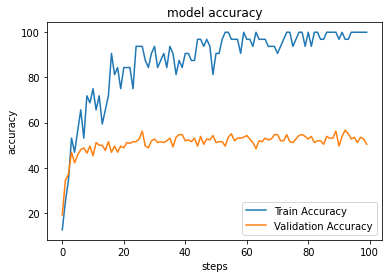

In [24]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.show()

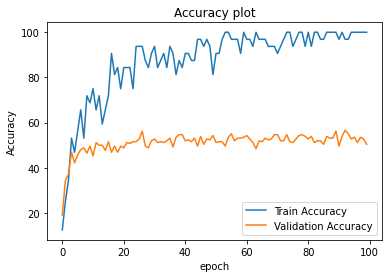

In [25]:
####### plot the the training accuracies here #########
num_epochs = 20

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend()
plt.show()

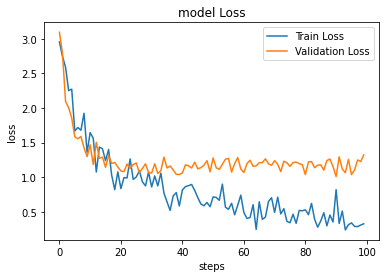

In [191]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()